# Ejercicio 8
El archivo semillas.csv contiene información de granos que pertenecen a tres variedades diferentes de
trigo. Entrene una neurona no lineal para determinar si una semilla es de “TIPO 2” o no. Divida el 60% de los
ejemplos para entrenar y el 40% para realizar el testeo. Antes de entrenar, normalice todos los atributos
numéricos aplicando media y desvío.
Realice los siguientes experimentos con el fin de analizar cómo distintos hiperparámetros afectan la
convergencia y el desempeño del modelo:

### a) 
Lleve a cabo 20 experimentos, utilizando la función sigmoide, variando la tasa de aprendizaje
desde α = 0.04, incrementando en pasos de 0.04 (es decir, α = 0.04, 0.08, ..., hasta 0.80). En cada
experimento, registre:
curva de error (error por iteración), curva de accuracy (precisión por iteración), cantidad total de
iteraciones realizadas, la iteración en la que se alcanzó el 100% de accuracy

Columnas del DataFrame: ['Area', 'Perimetro', 'Compacidad', 'LongNucleo', 'AnchoNucleo', 'Asimetria', 'LongSurco', 'Clase']

Primeras filas:
    Area  Perimetro  Compacidad  LongNucleo  AnchoNucleo  Asimetria  \
0  15.26      14.84      0.8710       5.763        3.312      2.221   
1  14.88      14.57      0.8811       5.554        3.333      1.018   
2  14.29      14.09      0.9050       5.291        3.337      2.699   
3  13.84      13.94      0.8955       5.324        3.379      2.259   
4  16.14      14.99      0.9034       5.658        3.562      1.355   

   LongSurco  Clase  
0      5.220  Tipo1  
1      4.956  Tipo1  
2      4.825  Tipo1  
3      4.805  Tipo1  
4      5.175  Tipo1  

Última columna:
0    Tipo1
1    Tipo1
2    Tipo1
3    Tipo1
4    Tipo1
Name: Clase, dtype: object

Forma de X: (210, 7)
Forma de y: (210,)
Distribución de clases - Tipo 2: 0, No Tipo 2: 210

Datos de entrenamiento: 126 ejemplos
Datos de testeo: 84 ejemplos
α=0.04: 334 iteraciones, 100% accuracy en 

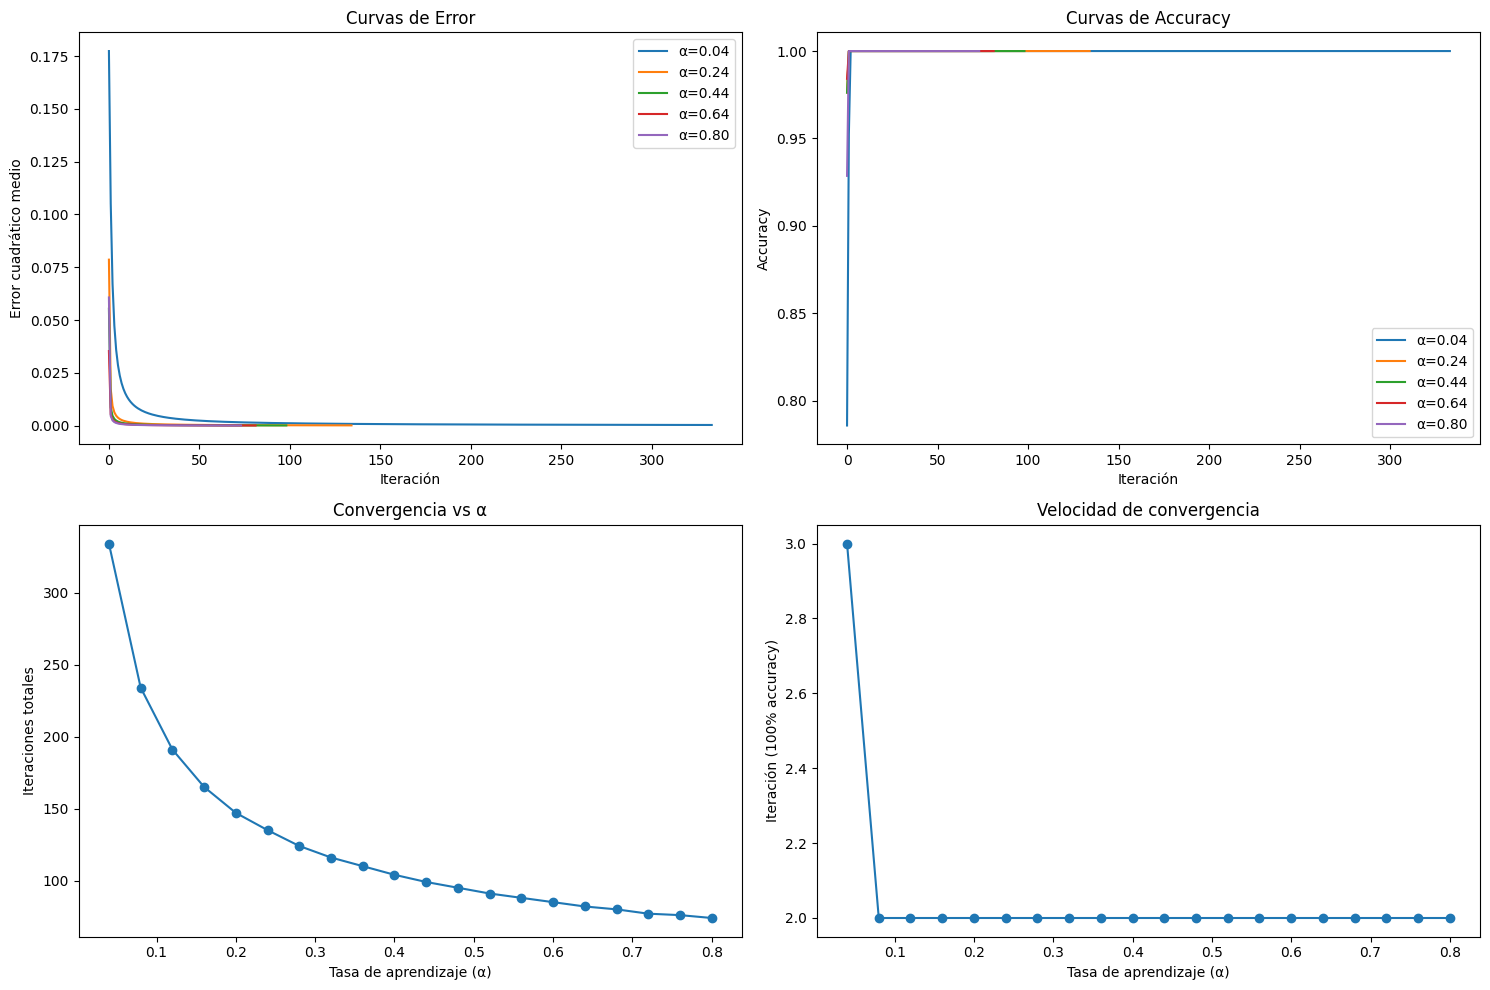

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Cargar y preparar datos
DATOS_DIR = '../../Datos/'

df = pd.read_csv(DATOS_DIR + 'semillas.csv', sep=',')

# Limpiar nombres de columnas (eliminar espacios)
df.columns = df.columns.str.strip()

# Verificar nombres de columnas
print("Columnas del DataFrame:", df.columns.tolist())
print("\nPrimeras filas:")
print(df.head())
print("\nÚltima columna:")
print(df.iloc[:, -1].head())

# Separar features y target (TIPO 2 vs no TIPO 2)
# Usar la última columna como target
X = df.iloc[:, :-1].values  # Todas las columnas excepto la última
y = (df.iloc[:, -1] == 2).astype(int).values  # 1 si es tipo 2, 0 si no

print(f"\nForma de X: {X.shape}")
print(f"Forma de y: {y.shape}")
print(f"Distribución de clases - Tipo 2: {y.sum()}, No Tipo 2: {len(y) - y.sum()}")

# Normalizar con media y desvío
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

# División 60% train, 40% test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.4, random_state=42)

print(f"\nDatos de entrenamiento: {len(X_train)} ejemplos")
print(f"Datos de testeo: {len(X_test)} ejemplos")

# 2. Función sigmoide y su derivada
def sigmoide(x):
    return 1 / (1 + np.exp(-x))

def derivada_sigmoide(y):
    return y * (1 - y)

# 3. Experimentos variando alpha
resultados = []
alphas = np.arange(0.04, 0.81, 0.04)  # 20 valores desde 0.04 hasta 0.80

for alfa in alphas:
    # Inicializar pesos aleatoriamente
    W = np.random.uniform(-0.5, 0.5, size=X_train.shape[1])
    b = np.random.uniform(-0.5, 0.5)
    
    MAX_ITE = 5000
    COTA = 1e-06
    
    historial_error = []
    historial_accuracy = []
    ite_100_accuracy = None
    
    ite = 0
    E_ant = 0
    E = 1
    
    while (ite < MAX_ITE) and (np.abs(E_ant - E) > COTA):
        E_ant = E
        sumaError = 0
        aciertos = 0
        
        for p in range(len(X_train)):
            # Forward pass
            neta = np.dot(W, X_train[p]) + b
            Y = sigmoide(neta)
            deriv = derivada_sigmoide(Y)
            
            # Calcular error
            Error = y_train[p] - Y
            
            # Actualizar pesos
            W = W + alfa * Error * deriv * X_train[p]
            b = b + alfa * Error * deriv
            
            # Acumular error cuadrático
            sumaError = sumaError + Error**2
            
            # Contar aciertos (umbral 0.5)
            prediccion = 1 if Y >= 0.5 else 0
            if prediccion == y_train[p]:
                aciertos += 1
        
        # Error medio y accuracy de la época
        E = sumaError / len(X_train)
        accuracy = aciertos / len(X_train)
        
        historial_error.append(E)
        historial_accuracy.append(accuracy)
        
        # Registrar iteración donde se alcanza 100% accuracy
        if accuracy == 1.0 and ite_100_accuracy is None:
            ite_100_accuracy = ite + 1
        
        ite += 1
    
    # Guardar resultados del experimento
    resultados.append({
        'alfa': alfa,
        'iteraciones_totales': ite,
        'ite_100_accuracy': ite_100_accuracy,
        'historial_error': historial_error,
        'historial_accuracy': historial_accuracy
    })
    
    print(f"α={alfa:.2f}: {ite} iteraciones, 100% accuracy en iteración {ite_100_accuracy}")

# 4. Graficar resultados
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Curvas de error para algunos alphas
for i, idx in enumerate([0, 5, 10, 15, 19]):  # Algunos ejemplos
    res = resultados[idx]
    axes[0, 0].plot(res['historial_error'], label=f"α={res['alfa']:.2f}")
axes[0, 0].set_xlabel('Iteración')
axes[0, 0].set_ylabel('Error cuadrático medio')
axes[0, 0].legend()
axes[0, 0].set_title('Curvas de Error')

# Curvas de accuracy
for i, idx in enumerate([0, 5, 10, 15, 19]):
    res = resultados[idx]
    axes[0, 1].plot(res['historial_accuracy'], label=f"α={res['alfa']:.2f}")
axes[0, 1].set_xlabel('Iteración')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].set_title('Curvas de Accuracy')

# Iteraciones totales vs alpha
axes[1, 0].plot([r['alfa'] for r in resultados], 
                [r['iteraciones_totales'] for r in resultados], 'o-')
axes[1, 0].set_xlabel('Tasa de aprendizaje (α)')
axes[1, 0].set_ylabel('Iteraciones totales')
axes[1, 0].set_title('Convergencia vs α')

# Iteración donde se alcanza 100% accuracy vs alpha
axes[1, 1].plot([r['alfa'] for r in resultados], 
                [r['ite_100_accuracy'] if r['ite_100_accuracy'] else 0 for r in resultados], 'o-')
axes[1, 1].set_xlabel('Tasa de aprendizaje (α)')
axes[1, 1].set_ylabel('Iteración (100% accuracy)')
axes[1, 1].set_title('Velocidad de convergencia')

plt.tight_layout()
plt.show()

### b) 
Replique el punto a) utilizando tangente hiperbólica.
